# Initialisation

In [1]:
from PyLQR.sim import KDLRobot
from PyLQR.system import PosOrnPlannerSys, PosOrnKeypoint
from PyLQR.solver import BatchILQRCP, BatchILQR, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import cv2
import matplotlib.cm as cm
from tqdm import tqdm

import logging
import sys

from scipy.spatial.transform import Rotation 

from contact_grasp.srv import *
from cv_bridge import CvBridge, CvBridgeError

sys.path.append("/home/vdrame/catkin_ws/src/py_panda/PyPanda")
from PyPanda import Robot
import rospy
from PyPanda import Utils

from utils.camera_utils import RealCamera, RealCameraROS
from utils.transform_utils import *
from utils.iLQR_wrapper import iLQR
from utils.visualisation_utils import depth2pc
from utils.ROS_utils import generate_grasps_client, format_pointcloud_msg, run_action, get_camera_pose

import argparse
from scipy.spatial.transform import Rotation

import time

from sensor_msgs.msg import Image, PointCloud2

import rospy
from contact_grasp.srv import contactGraspnetPointcloud2, contactGraspnetPointcloud2Response
# from contact_grasp.transform_utils import pose_inv

import json
from cv_bridge import CvBridge, CvBridgeError
from sensor_msgs import point_cloud2
from sensor_msgs.msg import PointField, CameraInfo
from std_msgs.msg import Header

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2023-06-12 19:03:13,702 - utils - NumExpr defaulting to 8 threads.
INFO - 2023-06-12 19:03:15,266 - base_toolkit - Could not load plugin 'qt' from 'pyface.ui.qt.init'
INFO - 2023-06-12 19:03:15,273 - base_toolkit - No pyface.toolkits plugin could be loaded for qt
INFO - 2023-06-12 19:03:15,278 - base_toolkit - Could not load traitsui.toolkits plugin 'qt' from 'traitsui.qt4'
INFO - 2023-06-12 19:03:15,282 - base_toolkit - Could not load traitsui.toolkits plugin 'wx' from 'traitsui.wx'
INFO - 2023-06-12 19:03:15,390 - base_toolkit - Could not load plugin 'qt4' from 'pyface.ui.qt.init'
INFO - 2023-06-12 19:03:15,391 - base_toolkit - No pyface.toolkits plugin could be loaded for qt4
INFO - 2023-06-12 19:03:15,391 - base_toolkit - Could not load traitsui.toolkits plugin 'qt4' from 'traitsui.qt4'


# Init communication

In [2]:
bridge = CvBridge()
try:
    rospy.init_node("python_node",anonymous=True)
except:
    print("rospy already initialized")
dispose_pos = np.array([0.1, 0.66, 0.1])
dispose_orn_wxyz = np.array([0, 1, 0.35, 0])

# Load robot
rbt = Robot("panda", use_gripper=True)
traj_gen = iLQR(rbt)

camera_connexion = "ROS"
if camera_connexion == "ROS":
    camera = RealCameraROS()
    intrinsic, distortion = camera.getIntrinsic()
elif camera_connexion == "pyWrapper":
    camera = RealCamera()
    camera.start()
    #retrieve image and depth to initialise camera, otherwise image is very dark
    for i in range(15):
        rgb, depth_image, depth_scale = camera.get_rgb_depth()
else:
    raise Exception("Please choose a valid camera connexion method: ROS or pyWrapper")

[WARN] [1686589407.063941]: No controllers are running


difference between iLQR model ee and real robot ee
quat (zyzw) :[ 3.5225025e-06 -1.3898479e-06 -1.2168058e-06  1.0000000e+00]
pos:[ 1.09408517e-06 -1.65821646e-06 -7.59780460e-07]
Camera topic found


# Function

In [3]:
def restart_controller(homing=False):
    eef_pos, eef_quat = [], []
    rbt.stop_controller()
    rbt.error_recovery()
    rbt.switch_controller("joint_velocity_controller")
    if homing:
        rbt.gripper.homing()

# Grasping

In [69]:
#load pos and orn from json file
with open('config/views_pos.json') as json_file:
    views_pos = json.load(json_file)
    
eef_pos, eef_quat = [], []
rbt.stop_controller()
rbt.error_recovery()
rbt.switch_controller("joint_velocity_controller")

[WARN] [1686591613.489944]: No controllers are running


True

In [70]:

pos_dif = 1000
keys = views_pos.keys()
angle_range = [-140, 40]
pc_fused = []
pc_colors_fused = []
reference_pose = np.eye(4)

for view_idx, key in enumerate(keys):
# while (not detected or not detected_with_collision):
    horizon = 30
    view_jpos, view_x_pos, view_U, view_Ks, view_ds, pos_dif, orn_dif = traj_gen.direct_trajectory(rbt.q, rbt.dq, views_pos[key]["pos"], views_pos[key]["orn_wxyz"], horizon)

    if pos_dif > 0.035:
        print("Trajectory could not reach view continue to next view")
        continue

    view_U = np.array(view_U)
    success, idx, eef_pos, eef_quat = run_action(rbt, view_U, 20)
    rbt.active_controller.send_command(np.zeros(7))
    time.sleep(0.075)
    
    img_cv, depth_cv, depth_scale = camera.get_rgb_depth()
    depth_cv = depth_cv * depth_scale
 
    current_pose = get_camera_pose(rbt, ee_depth=-0.1150)

    if view_idx == 0:
        init_pos = rbt.model.ee_pos_rel()
        init_orn_wxyz = rbt.model.ee_orn_rel()
        reference_pose = get_camera_pose(rbt, ee_depth=-0.1150)
        depth_init = depth_cv
        img_init = img_cv
        pc_fused, pc_colors_fused = depth2pc(depth_init, intrinsic, img_init)
        pc_fused, pc_colors_fused = regularize_pc(pc_fused, pc_colors_fused, 
                                                  downsampling_method="voxel", voxel_size=0.005,
                                                  outlier_filtering_method="radius", radius_param_arg=[25, 0.015])
    else:
        pc_fused, pc_colors_fused = add_view2pc(pc_fused, pc_colors_fused, reference_pose, current_pose, new_gbr=img_cv, 
                                                new_depth=depth_cv, cam_intrisic=intrinsic, regularize=True, voxel_size=0.005)
    pc2_msg = format_pointcloud_msg(pc_fused, pc_colors_fused)
    bgr_msg = bridge.cv2_to_imgmsg(img_init, encoding="bgr8")

    orn, pos, opening, score, detected, detected_with_collision = generate_grasps_client(pc2_msg, bgr_msg)

    if (detected or detected_with_collision) and opening > 0.03:
        grasp_pos_world, grasps_orn_world_xyzw = poseCam2World(pos, orn, reference_pose)      
        grasps_orn_world_xyzw = correct_angle(grasps_orn_world_xyzw, angle_range)
        grasp_orn_world_wxyz = convert_quat(grasps_orn_world_xyzw, to="wxyz")
        print("--------------------------------------------------------------------------")
        print("\n\ngrasps in world frame :\n pos :", grasp_pos_world, "\n grasps_orn_world :", grasps_orn_world_xyzw, "\ngrasp world rot",  Rotation.from_quat(grasps_orn_world_xyzw).as_euler("XYZ", degrees=True))
        print("------------------------------------ --------------------------------------")
        break
    # break

Downsampling time: 1.5929718017578125s, Filtering time: 0.09896016120910645s
calling service
detected : False
Downsampling time: 0.13260602951049805s, Filtering time: 0.20321249961853027s
calling service
detected : True
Readjuested angle
--------------------------------------------------------------------------


grasps in world frame :
 pos : [0.24008862 0.2142155  0.04462869] 
 grasps_orn_world : [ 0.9891909   0.13110289 -0.06404008  0.01457255] 
grasp world rot [177.36517908  -7.05803963 -15.26196797]
------------------------------------ --------------------------------------


# trajectory

1000
pos_dif:0.019019698559935527


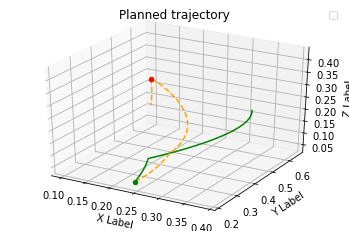

In [71]:
grasp_horizon = 60
grasp_jpos, grasp_x_pos, grasp_U, grasp_Ks, grasp_ds, pos_dif, orn_dif = traj_gen.grasping_trajectory(rbt.q, rbt.dq, grasp_pos_world, grasp_orn_world_wxyz, grasp_horizon)
pos_threshold = 0.015
if pos_dif > pos_threshold:
    print("grasp trajectory please change viewpose")
grasp_q = grasp_jpos[-1]
grasp_dq = np.zeros_like(grasp_q)
dispose_jpos, dispose_x_pos, dispose_U, dispose_Ks, dispose_ds, pos_dif, orn_dif = traj_gen.dispose_trajectory(grasp_q, grasp_dq, grasp_pos_world, grasp_orn_world_wxyz, dispose_pos, dispose_orn_wxyz, 120)
iLQR.plot_trajectory(init_pos, grasp_pos_world, grasp_x_pos, dispose_x_pos)


In [72]:
if opening + 0.015 <= 0.08:
    rbt.gripper.move(width=opening + 0.01)
else:
    rbt.gripper.move(width=0.08)
    
grasp_U = np.array(grasp_U)
success, idx, eef_pos, eef_quat = run_action(rbt, grasp_U[:-30], 20)
rbt.active_controller.send_command(np.zeros(7))
time.sleep(1)
success, idx, eef_pos, eef_quat = run_action(rbt, grasp_U[-30:], 20)
rbt.active_controller.send_command(np.zeros(7))
rbt.gripper.move(width=opening-0.015)

dispose_U = np.array(dispose_U)
success, idx, eef_pos, eef_quat = run_action(rbt, dispose_U, 20)
rbt.active_controller.send_command(np.zeros(7))
rbt.gripper.stop()
rbt.gripper.move(width=0.082)

True

In [ ]:
return_horizon = 60
return_jpos, return_x_pos, return_U, return_Ks, return_ds, pos_dif, orn_dif = traj_gen.direct_trajectory(rbt.q, rbt.dq, init_pos, init_orn_wxyz, return_horizon)
return_U = np.array(return_U)
success, idx, eef_pos, eef_quat = run_action(rbt, return_U, 20)
rbt.active_controller.send_command(np.zeros(7))

In [ ]:
rbt.stop_controller()

# Miscellaneous

## Get end effector pos

In [ ]:
print("rbt end effector pos:", rbt.model.ee_pos_rel())
print("rbt end effector quat (wxyz):", rbt.model.ee_orn_rel())
print("eef rot",  Rotation.from_quat(convert_quat(rbt.model.ee_orn_rel(), to="xyzw")).as_euler("xyz", degrees=True))


## Show pc with open3d

In [ ]:
import open3d as o3d
pc_o3d = o3d.geometry.PointCloud()
pc_o3d.points = o3d.utility.Vector3dVector(pc_fused)
pc_o3d.colors = o3d.utility.Vector3dVector(pc_colors_fused/255)
coordinate = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
coordinate.translate([0,0 , 0.4])
o3d.visualization.draw_geometries([coordinate, pc_o3d])